In [1]:
%load_ext autoreload

In [2]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
assert tf.config.list_physical_devices('GPU')

import collections

import dataset

%autoreload
import transformer

In [3]:
BATCH_SIZE = 32

MAXLEN = 50

LETTERS_SIZE = len(dataset.letters_table)
NIQQUD_SIZE = len(dataset.niqqud_table)
DAGESH_SIZE = len(dataset.dagesh_table)
SIN_SIZE = len(dataset.sin_table)

num_layers = 1
num_heads = 4
d_model = 220 // num_heads * num_heads
dff = 1024

model = transformer.Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=LETTERS_SIZE,
    output_sizes=[NIQQUD_SIZE, DAGESH_SIZE, SIN_SIZE],
    maximum_position_encoding_input=MAXLEN,
    maximum_position_encoding_target=MAXLEN,
    rate=0.0
)

learning_rate = transformer.CustomSchedule(d_model, warmup_steps=3000)
lr = 12e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss='sparse_categorical_crossentropy',  # transformer.MaskedCategoricalCrossentropy(),  # tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']  # unmasked, so incorrect
)
# pseudo "build" step, to allow printing a summary:
# model.run_eagerly = True
h = model.pseudo_build(MAXLEN, MAXLEN)
model.summary()
model.save_weights('./checkpoints/uninit')

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  656844    
_________________________________________________________________
decoder (Decoder)            multiple                  847144    
_________________________________________________________________
softmax (Softmax)            multiple                  0         
_________________________________________________________________
dense_16 (Dense)             multiple                  3536      
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
_________________________________________________________________
dense_17 (Dense)             multiple                  663       
_________________________________________________________________
softmax_2 (Softmax)          multiple                  

In [4]:
def load_data(source, validation=0.1):
    filenames = [os.path.join('texts', f) for f in source]
    train, valid = dataset.load_data(filenames, validation, maxlen=MAXLEN)
    return train, valid


def batch_zip(d):
    for i in range(len(d.normalized) // BATCH_SIZE):
        s = slice(i*BATCH_SIZE, (i+1)*BATCH_SIZE)
        yield (i, d.normalized[s], [d.niqqud[s], d.dagesh[s], d.sin[s]])
    

def fit(data, epochs=1):
    train, valid = data
    total_train = len(train)//BATCH_SIZE
    total_valid = len(valid)//BATCH_SIZE
    history = collections.defaultdict(list)
    for epoch in range(epochs):
        model.reset_metrics()
        for batch, x, ys in batch_zip(train):
            res = model.train_step(x, *ys)
            
            print(f"\r({epoch}) {batch:4d}/{total_train:4d} - {' - '.join(f'{k}: {v:.4f}' for k, v in res.items())}", end='')
            
        model.reset_metrics()
        
        for batch, x, ys in batch_zip(valid):
            res = model.test_step(x, *ys)

        print(''.join(f" - {k}: {v:.4f}" for k, v in res.items()))
        
        for k, v in res.items():
            history[k].append(res[k].numpy())

    return history

In [5]:
data_other = load_data(['biblical', 'garbage'])

In [6]:
data_mix = load_data(['poetry', 'rabanit', 'pre_modern'])

In [7]:
data_modern = load_data(validation=0.1, source=['modern'])

In [8]:
model.load_weights('./checkpoints/uninit')
history = fit(data_other, epochs=1)
model.save_weights('./checkpoints/other')

(0) 1810/1811 - loss: 0.2502 - output_1_accuracy: 0.8002 - output_2_accuracy: 0.9645 - output_3_accuracy: 0.9878 - val_loss: 0.5478 - val_output_1_accuracy: 0.8503 - val_output_2_accuracy: 0.9522 - val_output_3_accuracy: 0.9919


In [9]:
model.load_weights('./checkpoints/other')
history = fit(data_mix, epochs=1)
model.save_weights('./checkpoints/mix')

(0) 5717/5718 - loss: 0.0851 - output_1_accuracy: 0.9272 - output_2_accuracy: 0.9884 - output_3_accuracy: 0.9982 - val_loss: 0.3366 - val_output_1_accuracy: 0.9079 - val_output_2_accuracy: 0.9729 - val_output_3_accuracy: 0.9979


In [11]:
model.load_weights('./checkpoints/mix')
history = fit(data_modern, epochs=1) # lr=0.0012, d_model=220, num_layers=1, num_heads=4, dff=512 - accuracy: 0.8314
print(f'{lr=}, {d_model=}, {num_layers=}, {num_heads=}, {dff=}')
model.save_weights('./checkpoints/modern')

(0)  680/ 681 - loss: 0.0669 - output_1_accuracy: 0.9447 - output_2_accuracy: 0.9885 - output_3_accuracy: 0.9991 - val_loss: 0.2960 - val_output_1_accuracy: 0.9232 - val_output_2_accuracy: 0.9726 - val_output_3_accuracy: 0.9975
lr=0.0012, d_model=220, num_layers=1, num_heads=4, dff=1024


In [12]:
model.load_weights('./checkpoints/modern')

def print_predictions(data, s):
    batch = data.normalized[s]
    [actual_niqqud, actual_dagesh, actual_sin] = model.predict_argmax(batch)
    [expected_niqqud, expected_dagesh, expected_sin] = [data.niqqud[s], data.dagesh[s], data.sin[s]]
    actual = dataset.merge(data.text[s], ts=batch, ns=actual_niqqud, ds=actual_dagesh, ss=actual_sin)
    expected = dataset.merge(data.text[s], ts=batch, ns=expected_niqqud, ds=expected_dagesh, ss=expected_sin)
    total = []
    for i, (a, e) in enumerate(zip(actual, expected)):
        print('מצוי: ', a)
        print('רצוי: ', e)
        last = expected_niqqud[i].tolist().index(0)
        res = expected_niqqud[i][:last] == actual_niqqud[i][:last]
        total.extend(res)
        print(f'{np.mean(res):.2f} ({last - sum(res)} out of {last})')
        print()
    print(round(np.mean(total), 3))

print_predictions(data_modern[1], slice(0, BATCH_SIZE))

מצוי:  בִּמְלַאי הַדִּירוּת עֲשׂוּיָה לִהְיוֹת בְּעָתִיד הַגּוֹרֵם הַמֶּרְכָּזִי 
רצוי:  בִּמְלַאי הַדִּירוֹת עֲשׂוּיָה לִהְיוֹת בֶּעָתִיד הַגּוֹרֵם הַמֶּרְכָּזִי 
0.95 (2 out of 44)

מצוי:  זוֹ רוֹתִי שְׁבִיקְּשָׁה. אַפְּרוֹפוֹ מְתִיחַת קַדָּם שִׁיעוּר: בְּנָעִים גַּם 
רצוי:  זוֹ רוּתִי שֶׁבִּיקְּשָׁה. אַפְּרוֹפּוֹ מְתִיחַת קְדַם שִׁיעוּר: בְּנָעִים גַּם 
0.92 (4 out of 49)

מצוי:  נוֹסָפִים. מִדִּיוּוּחֵי הַבַּנְּק הַמֶּרְכָּזִי בְּסַפְרָד, הַמְּצוּיָה בְּמִיתּוּן 
רצוי:  נוֹסָפִים. מִדִּיוּוּחֵי הַבַּנְק הַמֶּרְכָּזִי בִּסְפָרַד, הַמְּצוּיָה בְּמִיתּוּן 
0.92 (4 out of 49)

מצוי:  הָאִישָּׁה הִיא מַרְכִּיב עִיקָּרִי בָּהּ. אַנְדְּרִיאָה דַּוְורקִין מַגְדִּירָה 
רצוי:  הָאִישָּׁה הִיא מַרְכִּיב עִיקָּרִי בָּהּ. אַנְדְרֵיאָה דְּווֹרְקִין מַגְדִּירָה 
0.90 (5 out of 49)

מצוי:  מוּסָרִית זוֹ בָּאָה לְשַׁמֵּשׁ חֲלוּפָה לְמוּסָּר הָרוֹמָאִי הַמְּשׁוּחְרָר. 
רצוי:  מוּסָרִית זוֹ בָּאָה לְשַׁמֵּשׁ חֲלוּפָה לַמּוּסָר הָרוֹמָאִי הַמְּשׁוּחְרָר. 
0.98 (1 out of 47)

מצוי:  מֵהַהוֹרִים, אָז אֵ

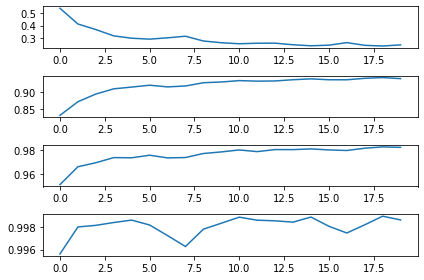

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(history), ncols=1)

for i, v in enumerate(history.values()):
    ax[i].plot(v)

plt.tight_layout()